In [1]:
using ComputationalHeatTransfer

In [2]:
# using Plots
using LaTeXStrings

In [3]:
using Revise
using LinearAlgebra
using DifferentialEquations
using Plots
pyplot()

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise C:\Users\liyux\.julia\packages\Revise\1boD5\src\packagedef.jl:1369


Plots.PyPlotBackend()

In [4]:
cd(dirname(pwd()))
cd("src") 

includet("OneDOHP.jl")
using ..OneDOHP

### Physical parameters

In [5]:
ρ = 2702;
c = 9.03e02;
k = 2.37e02;
d = 1e-3;
params = HeatConductionParameters(ρ,c,k,thickness=d)

HeatConductionParameters(1.0, 1.0, 0.1, 0.1, 0.1)

In [6]:
xlim = (-2.0,2.0)
ylim = (-2.0,2.0)
# Δx, Δt = setstepsizes(params.α,gridPe=0.1,fourier=200.0)
Δx, Δt = setstepsizes(params.α,gridPe=0.4,fourier=20.0)

(0.04000000000000001, 0.032000000000000015)

### Set up the evaporator and condenser

In [7]:
eb = Rectangle(0.5,0.5,1.5*Δx)
Te = RigidTransform((-0.5,0.5),0.0)
Te(eb)
cb = Rectangle(0.5,0.5,1.5*Δx)
Tc = RigidTransform((0.5,-0.5),0.0)
Tc(cb)

qe = 10.0
hc = 10.0
Tc = -50.0

eparams = PrescribedHeatFluxRegion(qe,eb);
cparams = PrescribedHeatModelRegion(hc,Tc,cb);

### Set up the OHP

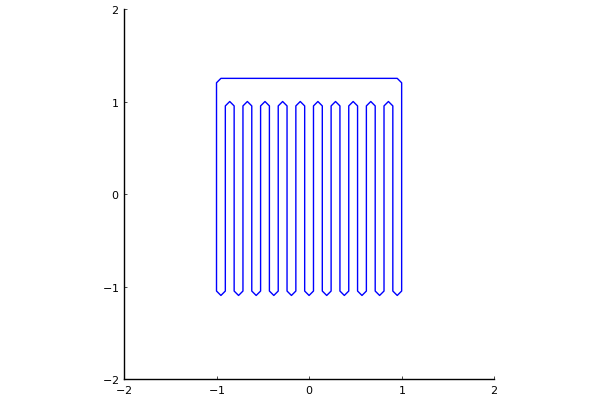

In [8]:
ds = 1.5Δx
nturn = 10
#pitch = 0.125
length_ohp = 2.0
height = 2.0
gap = 0.25
pitch = length_ohp/(2*nturn+1)
x0, y0 = -length_ohp/2, 1.25
x, y, xf, yf = ComputationalHeatTransfer.construct_ohp_curve(nturn,pitch,height,gap,ds,x0,y0,false,false,0.0)
ohp = BasicBody(x,y)

plot(ohp,fillalpha=0,linecolor=:blue,xlims=xlim,ylims=ylim)

In [9]:
ohpgeom = ComputationalHeatTransfer.LineSourceParams(ohp)
qtmp = zeros(numpts(ohp));

### Create the system

In [10]:
sys = HeatConduction(params,Δx,xlim,ylim,Δt,qflux=eparams,qmodel=cparams,qline=ohpgeom)
#sys = HeatConduction(params,Δx,xlim,ylim,Δt,qline=ohpgeom)

Unbounded Heat conduction system on a grid of size 104 x 104 and 0 static immersed points


#### Initialize state, and create the integrator

In [52]:
u0 = newstate(sys)
# tspan = (0.0,1.0)
tspan = (0.0,0.1)
integrator = init(u0,tspan,sys)

t: 0.0
u: (Primal nodes in a (nx = 104, ny = 104) cell grid of type Float64 data
  Number of Primal nodes: (nx = 103, ny = 103), Float64[])

# OHP inner part

In [53]:
    ω = sqrt(1.68e003);
    ℘L = 6.2e004;
    k = 115e-003

    θinitial=1.0
    θc = 1.0;

    Hwc = 0.0; #not useful later on. H between wall and condenser, 
    Hₗ   =  1600.0; # liquid wall heat transfer coeffcient
    Hδ  = 7.34e002;


In [54]:
    
    d = 6.56e-3 # dimensionless diameter
    L = 35.0  # total length of the pipe when streched to a 1D pipe
    L2D = 1.0 # the actual length of the bended pipe in the real world
    angle = pi/2 # inclination angle 
    closedornot = true

true

In [55]:
    nucleatenum = 1
    Xstations = sort(rand(nucleatenum).*L);
#     boilingΔt = 0.05

In [56]:
tube = Tube(d,L,L2D,angle,closedornot);

In [57]:
Xe = map(tuple, [1.0], [3.0])
We = [0.0]
evap = Evaporator(Xe,We);

In [58]:
Xc = map(tuple, [0.0,3.0], [1.0,4.0])
cond = Condenser(θc,Xc,Hwc);

In [59]:
N=numpts(ohp)
X0 = [(L/4, L*3/4)]
dXdt0 = [(0.0,0.0)]
ρ = 214.6
Xarrays,θarrays = constructXarrays(X0,N,θinitial,L)
liquids=Liquid(Hₗ,ρ,ω,℘L,X0,dXdt0,Xarrays,θarrays);

In [60]:
# P = [1.0,1.0,1.0,1.0,1.0]; # closed end

γ = 1.4;
Hδ = 7.34e2
P = [1.0];
δ = [2.86e-02];
vapors=Vapor(γ,Hδ,P,δ);

In [61]:
α = 0 # nondimensional thermal diffusivity = (αₐ d^2) / (νₗ height^2)
Xwallarray,θwallarray = constructXarrays(L,N,θinitial)

wall = Wall(α,Δt,Xstations,Xwallarray,θwallarray);

In [62]:
walltoliquid, liquidtowall = constructmapping(Xarrays,Xwallarray,closedornot,L)
mapping = Mapping(walltoliquid,liquidtowall);

In [63]:
sys0 = PHPSystem(tube,evap,cond,liquids,vapors,wall,mapping);

## construct state vector U

In [64]:
Lvaporplug = XptoLvaporplug(X0,sys0.tube.L,sys0.tube.closedornot)
M = P.^(1/γ).* Lvaporplug


u=[XMδtovec(X0,dXdt0,M,δ); wallθtovec(sys0.wall.θarray); liquidθtovec(sys0.liquid.θarrays)];

In [65]:
cb_boiling =  DiscreteCallback(boiling_condition,boiling_affect!)
cb_merging =  DiscreteCallback(merging_condition,merging_affect!)

cb = CallbackSet(cb_boiling,cb_merging)

CallbackSet{Tuple{},Tuple{DiscreteCallback{typeof(boiling_condition),typeof(boiling_affect!),typeof(DiffEqBase.INITIALIZE_DEFAULT),typeof(DiffEqBase.FINALIZE_DEFAULT)},DiscreteCallback{typeof(merging_condition),typeof(merging_affect!),typeof(DiffEqBase.INITIALIZE_DEFAULT),typeof(DiffEqBase.FINALIZE_DEFAULT)}}}((), (DiscreteCallback{typeof(boiling_condition),typeof(boiling_affect!),typeof(DiffEqBase.INITIALIZE_DEFAULT),typeof(DiffEqBase.FINALIZE_DEFAULT)}(boiling_condition, boiling_affect!, DiffEqBase.INITIALIZE_DEFAULT, DiffEqBase.FINALIZE_DEFAULT, Bool[1, 1]), DiscreteCallback{typeof(merging_condition),typeof(merging_affect!),typeof(DiffEqBase.INITIALIZE_DEFAULT),typeof(DiffEqBase.FINALIZE_DEFAULT)}(merging_condition, merging_affect!, DiffEqBase.INITIALIZE_DEFAULT, DiffEqBase.FINALIZE_DEFAULT, Bool[1, 1])))

## solve OHP

In [66]:
tstep=1e-4

p = sys0
tspan = (0.0, 0.2);
prob = ODEProblem(ODE_innertube, u, tspan, p)

integrator_tube = init(prob, RK4(), dt=tstep, callback=cb);


solve!(integrator_tube);



### Set up values for the OHP heat flux per unit length and advance the solution

In [67]:
fill!(qtmp,-1.0)
set_linesource_strength!(sys,qtmp)

Unbounded Heat conduction system on a grid of size 104 x 104 and 0 static immersed points


In [68]:
step!(integrator,1.0)

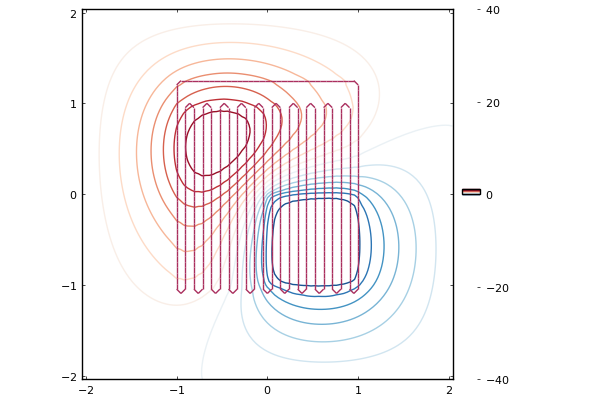

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [69]:
plot(temperature(integrator),sys.grid,legend=true,color=cgrad(:RdBu,rev=true))
plot!(ohp,fillalpha=0,line_z=qtmp)

### Now change the values for the OHP heat flux per unit length and advance further

In [70]:
fill!(qtmp,-10.0)
set_linesource_strength!(sys,qtmp)

Unbounded Heat conduction system on a grid of size 104 x 104 and 0 static immersed points


In [71]:
step!(integrator,1.0)

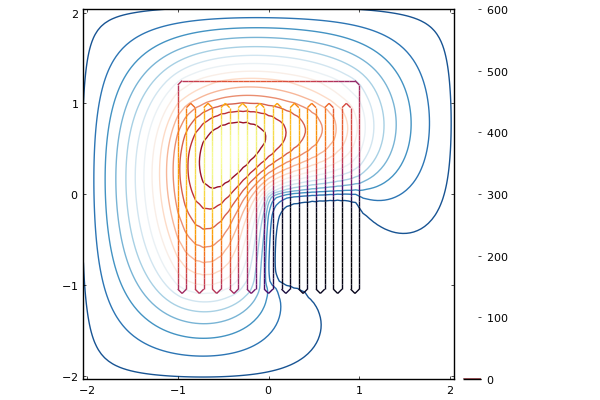

In [72]:
plot(temperature(integrator),sys.grid,legend=true,color=cgrad(:RdBu,rev=true))
plot!(ohp,fillalpha=0,line_z=temperature_linesource(integrator))

### Plot the temperature along the OHP channel

In [73]:
temperature(integrator)

Nodes{Primal,104,104,Float64,Array{Float64,2}} data
Printing in grid orientation (lower left is (1,1))
103×103 Array{Float64,2}:
 0.88334    1.45923   2.06071   2.66723  …   1.61477     1.1425     0.691239
 1.45848    2.40937   3.40255   4.40407      2.66436     1.88508    1.14048
 2.05806    3.39992   4.80149   6.21493      3.75584     2.65725    1.60761
 2.66104    4.39611   6.20848   8.03633      4.84954     3.43094    2.07564
 3.26495    5.39389   7.61783   9.86096      5.93976     4.20209    2.5421
 3.86997    6.39356   9.02995  11.6894   …   7.02557     4.97004    3.00659
 4.47622    7.39533  10.4452   13.522        8.10596     5.73405    3.46866
 5.08372    8.39922  11.8635   15.3591       9.17963     6.49319    3.92774
 5.69238    9.40512  13.2849   17.2003      10.2451      7.24643    4.3832
 6.30205   10.4128   14.7089   19.0452      11.3007      7.99255    4.8343
 6.91248   11.4218   16.1351   20.8932   …  12.3446      8.73022    5.28023
 7.5233    12.4315   17.5624   22.743

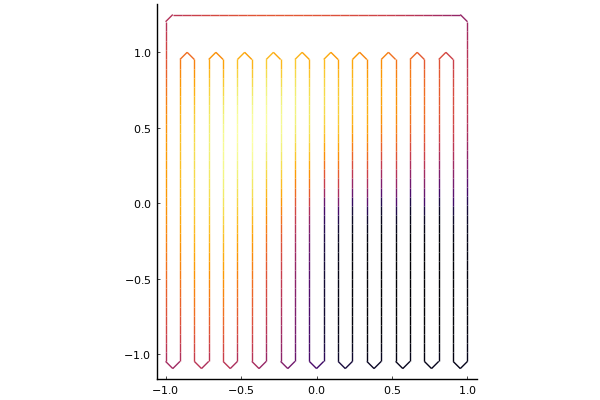

In [74]:
plot(ohp,fillalpha=0,line_z=temperature_linesource(integrator))

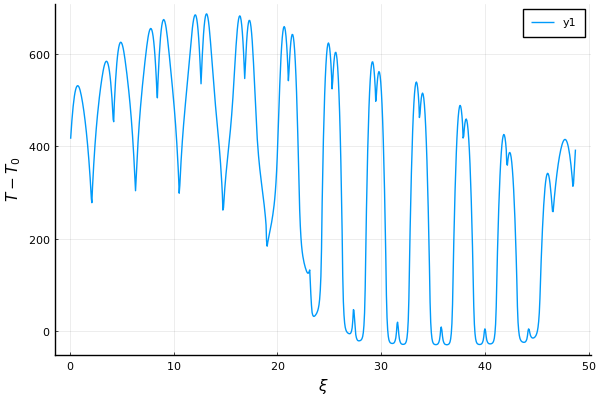

In [75]:
plot(sys.qline[1].arccoord,temperature_linesource(integrator),xlabel=L"\xi",ylabel=L"T - T_0")

## combine inner tube and plate together

In [37]:
u0 = newstate(sys)
integrator = init(u0,tspan,sys)

t: 0.0
u: (Primal nodes in a (nx = 104, ny = 104) cell grid of type Float64 data
  Number of Primal nodes: (nx = 103, ny = 103), Float64[])

In [38]:
integrator_inner = init(prob, RK4(),save_everystep=false, callback=mergingcb);

LoadError: [91mUndefVarError: mergingcb not defined[39m

In [39]:
step!(integrator_inner, tstep, true)

integrator_inner

LoadError: [91mUndefVarError: integrator_inner not defined[39m

In [40]:
    currentsys = getcurrentsys(integrator_inner.u,p)
    
    currentsys.wall.θarray = temperature_linesource(integrator)
    
    current_u = deepcopy(integrator_inner.u)
    current_u[end-length(currentsys.wall.θarray)+1:end] = currentsys.wall.θarray
    set_u!(integrator_inner, u)
    step!(integrator_inner, tstep, true)



LoadError: [91mUndefVarError: integrator_inner not defined[39m

In [41]:
@time for t in tspan[1]:tstep:0.01tspan[2]
    currentsys = getcurrentsys(integrator_inner.u,p)
    
    currentsys.wall.θarray = temperature_linesource(integrator)
    
    qtmp = sys_to_heatflux(currentsys)
    set_linesource_strength!(sys,qtmp)
    step!(integrator)
    
    current_u = deepcopy(integrator_inner.u)
    current_u[end-length(currentsys.wall.θarray)+1:end] = currentsys.wall.θarray
    set_u!(integrator_inner, u)
    step!(integrator_inner, tstep, true)

    # get q
    # reinitialize q
    # step!(integrator)
end

LoadError: [91mUndefVarError: integrator_inner not defined[39m